# Ex 2. Low-activity patterns
**2.1.** We now study the capacity of a Hopfield network with stochastic binary neurons and low-activity patterns. This model is proposed in the paper by [Tsodyks and Feigel’man (1988)] and discussed briefly in Chapter 17.2.6 of the book Neuronal Dynamics.

Standard Hopfield model could be described by the following equations:

\begin{equation}
w_{ij} = c \sum_{\mu=1}^{M} p_{i}^{\mu}p_{j}^{\mu}
\end{equation}

\begin{equation}
S_{i}(t+1) = \phi(\sum_{j} w_{ij} S_{j}(t))
\end{equation}
Taking $p_{i}^{\mu} = 2\xi_{i}^{\mu}-1$ we can substitute it into expression (1):
\begin{equation}
    w_{ij} = c \sum_{\mu=1}^{M} (2\xi_{i}^{\mu}-1)(2\xi_{j}^{\mu}-1)
\end{equation}

$$ = 4c \sum_{\mu=1}^{M} (\xi_{i}^{\mu}-\frac{1}{2})(\xi_{j}^{\mu}-\frac{1}{2})$$
$$ = 4c \sum_{\mu=1}^{M} (\xi_{i}^{\mu}-a)(\xi_{j}^{\mu}-b)$$
Hence, from this expression we can deduce that if $a=b=0.5$ with $c^{'}=4c$, we arrive at the Standard Hopfiel model.

In [93]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
def generate_patterns(M, N):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    return np.random.choice([0, 1], size=(M, N))


class StochasticHopfieldNetwork:
    def __init__(self, size, a, b, c, beta=4, theta=0):
        self.size = size
        self.theta = theta  # Threshold for neuron firing
        self.a = a
        self.b = b
        self.c = c
        self.beta = beta
    
    def stochastic_spike_variable(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def train(self, patterns, size):
        W = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if i != j:
                    W[i, j] = self.c / size * np.sum((patterns[:, i] - self.b) * (patterns[:, j] - self.a))
        #new_S = np.tanh(beta*(W@S - theta))
        return W
    
    def recall(self, state, patterns, steps=5):
        state = np.array(state, dtype=float)  # continuous states initialized with the pattern
        for _ in range(steps):
            sigma = self.stochastic_spike_variable(state) # P{σ_i(t) = +1 | S_i(t)}
            weights = self.train(patterns, self.size)
            continuous_state = np.dot(weights, sigma) - self.theta  
            state = np.tanh(continuous_state*self.beta)  # Stochastic state update
            print("Similarity between the 1st pattern and the current state:", round(np.dot(state,patterns[0,:])/len(state),4))
        for i in range(len(patterns)):
            print("Similarity between the",i+1,"pattern and the current state:", round(np.dot(state,patterns[i,:])/len(state),4))
        #return state

In [135]:
# Example usage:
size = 100
patterns = generate_patterns(10, size)  # Low-activity patterns
# flip 5% of indices
initial_state = patterns[0].copy()
const = 0.05
flip_indices = np.random.choice(len(initial_state), int(size*const), replace=False)
initial_state[list(flip_indices)] *= -1
#print(initial_state==patterns[0])

stochastic_net = StochasticHopfieldNetwork(size, a=0.5, b=0.5, c=4.0, theta=0, beta=4)
stochastic_net.train(patterns, size)
#print(patterns)
recalled = stochastic_net.recall(initial_state,patterns)
#print(recalled)

Similarity between the 1st pattern and the current state: 0.3143
Similarity between the 1st pattern and the current state: 0.3527
Similarity between the 1st pattern and the current state: 0.3008
Similarity between the 1st pattern and the current state: 0.2301
Similarity between the 1st pattern and the current state: 0.1712
Similarity between the 1 pattern and the current state: 0.1712
Similarity between the 2 pattern and the current state: -0.0914
Similarity between the 3 pattern and the current state: -0.0875
Similarity between the 4 pattern and the current state: -0.0627
Similarity between the 5 pattern and the current state: -0.2246
Similarity between the 6 pattern and the current state: -0.0629
Similarity between the 7 pattern and the current state: -0.1272
Similarity between the 8 pattern and the current state: 0.1612
Similarity between the 9 pattern and the current state: 0.0676
Similarity between the 10 pattern and the current state: -0.0018


### Question
Are we supposed to show with which values we get the same patterns as we do for Hopfield model or would it be enough to just state it?

a=b=0.5, c=1

**2.2.** Write methods for generating random patterns ξμ ∈ {0, 1}N with activity (i.e. average number of
(+1)’s) a, for computing the Hamming distance between new patterns ξμ and new state variables σ, and
for simulating the new model above.

In [ ]:
'''
for M in range(1, max_patterns + 1):
            patterns = self.generate_random_patterns(M)
            self.train(patterns)
            initial_state = patterns[0].copy()  # Testing recall for the first pattern
            recalled_state = self.recall(initial_state)
            if np.sum(recalled_state != patterns[0]) / self.size > 0.05:  # Using 10% error rate
                return M - 1  # Return the last successfully recalled number of patterns
        return M
'''

In [312]:
def generate_patterns(M, size):
    """
    Args:
        M: number of patterns
        N=size: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M,size))
    a = np.sum(patterns, axis=1) / size
    return a, patterns

#a, patterns = generate_patterns(3, 10)
class StochasticHopfieldNetwork:
    def __init__(self, size, a, b, c, beta=4, theta=0):
        self.size = size
        self.theta = theta  # Threshold for neuron firing
        self.a = a
        self.b = b
        self.c = c
        self.beta = beta
    
    def stochastic_spike_variable(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def overlap(self, patterns, sigma):
        m = np.zeros(patterns.shape[0])
        for i in range(len(m)):
            m[i] = self.c / self.size * np.sum((patterns[i, :] - self.a[i])*sigma)
        return m
    
    def recall(self, state, patterns, steps=20):
        state = np.array(state, dtype=float)  # continuous states initialized with the pattern
        for _ in range(steps):
            sigma = self.stochastic_spike_variable(state) # P{σ_i(t) = +1 | S_i(t)}
            overlaps = self.overlap(patterns, sigma)
            continuous_state = np.dot(patterns.T,overlaps) - self.theta  
            state = np.tanh(continuous_state*self.beta)  # Stochastic state update
            #print("Similarity between the 1st pattern and the current state:", round(np.dot(state,patterns[0,:])/len(state),4))
        #for i in range(len(patterns)):
            #print("Similarity between the",i+1,"pattern and the current state:", round(np.dot(state,patterns[i,:])/len(state),4))
        return state
    
    def hamming_distance(self, pattern, state):
        """Calculates the Hamming distance between two states."""
        sigma = self.stochastic_spike_variable(state)
        return (self.size-np.dot(pattern, sigma))/(2*self.size)

    def compute_capacity(self, generate_patterns):
        M_max = 0
        a, patterns = generate_patterns(10, self.size)
        for mu in range(patterns.shape[0]):
            initial_state = patterns[mu].copy()
            flip_indices = np.random.choice(len(initial_state), int(size*0.05), replace=False)
            initial_state[list(flip_indices)] *= -1
            recalled_state = self.recall(initial_state, patterns)
            sigma = self.stochastic_spike_variable(recalled_state)
            #sigma = self.stochastic_spike_variable(patterns[mu])
            #print("sigma:",sigma)
            #print("pattern:",patterns[mu])
            hamming_dist = self.hamming_distance(patterns[mu]-a[mu], sigma)
            print(hamming_dist)
            if hamming_dist < 0.05:
                #print(hamming_dist)
                M_max += 1
        return M_max/N
        

In [313]:
# Example usage:
size = 300
a, patterns = generate_patterns(10, size)
stochastic_net = StochasticHopfieldNetwork(size, a=a, b=0.5, c=4.0, theta=0, beta=4)

# flip 5% of indices
initial_state = patterns[0].copy()
const = 0.05
flip_indices = np.random.choice(len(initial_state), int(size*const), replace=False)
initial_state[list(flip_indices)] *= -1

recalled = stochastic_net.recall(initial_state,patterns)
#print(recalled)

What does the hint mean?

**2.3.** Using the parameters a, b, θ that you found in question 2.1, compute the capacity of the network for N = 300.
Is it the same as what you found in the previous section? If not, what do you think is the origin of the discrepancy?

In [314]:
# Parameters
capacity = stochastic_net.compute_capacity(generate_patterns, 300)
# flip 5% of indices
#initial_state = patterns[0].copy()
#const = 0.05
#flip_indices = np.random.choice(len(initial_state), int(size*const), replace=False)
#initial_state[list(flip_indices)] *= -1
# Create the network and compute its capacity
#stochastic_net = StochasticHopfieldNetwork(size, a=a, b=0.5, c=4.0, theta=0, beta=4)
#recalled = stochastic_net.recall(initial_state,patterns)
#capacity = stochastic_net.compute_capacity(patterns, recalled)  # Test with up to 100 patterns
print("Estimated capacity of the network:", capacity)

0.5091666666666667
0.4990833333333333
0.4874
0.5133111111111112
0.5237833333333333
0.48900000000000005
0.47466666666666657
0.5095888888888889
0.5121444444444444
0.5091777777777777
Estimated capacity of the network: 0.0


### Questions to TA:
1. When computing Hamming distance, are we computing it between the sigma of the state that we have updated and the random patterns or the sigma of the pattern and the pattern itself (for every pattern)?

**2.4.** For a = b = 0.5, what value of the threshold θ corresponds to the best capacity? Plot the capacity as a function of θ.

In [311]:
# Parameters
N = 300 # number of neurons in patterns
a = 0.5 # Low activity level of 10%
b = 0.5  # No offset for binary patterns
c = 4
beta = 4
theta = np.linspace(0, 10, 20)
capacity = np.zeros(len(theta))

# Create the network and compute its capacity
for i,t in enumerate(theta):
    a, patterns = generate_patterns(10, N)
    network = StochasticHopfieldNetwork(N, a, b, c, beta, theta=t)
    # flip 5% of indices
    initial_state = patterns[0].copy()
    flip_indices = np.random.choice(len(initial_state), int(N*0.05), replace=False)
    initial_state[list(flip_indices)] *= -1

    recalled = network.recall(initial_state,patterns)
    capacity[i] = network.compute_capacity(generate_patterns, N)  # Test with up to 100 patterns
    #print("Theta:", t, "Estimated capacity of the network:", capacity)
#network = StochasticHopfieldNetwork(N, a, b, beta, theta)
#capacity = network.compute_capacity(100)  # Test with up to 100 patterns
print("Estimated capacity of the network:", capacity)

0.2783333333333333
0.31333333333333335
0.34
0.295
0.3283333333333333
0.33666666666666667
0.3333333333333333
0.3383333333333333
0.31666666666666665
0.2966666666666667
0.36333333333333334
0.37333333333333335
0.37
0.3883333333333333
0.38
0.38166666666666665
0.39
0.3616666666666667
0.38666666666666666
0.4
0.36666666666666664
0.3466666666666667
0.39166666666666666
0.375
0.3616666666666667
0.37
0.37833333333333335
0.36666666666666664
0.38166666666666665
0.37833333333333335
0.37
0.365
0.365
0.38666666666666666
0.38333333333333336
0.3566666666666667
0.38
0.38
0.36666666666666664
0.385
0.3616666666666667
0.3616666666666667
0.3516666666666667
0.36
0.37166666666666665
0.36333333333333334
0.3933333333333333
0.3566666666666667
0.37833333333333335
0.4033333333333333
0.37166666666666665
0.3933333333333333
0.37666666666666665
0.39166666666666666
0.37666666666666665
0.345
0.375
0.35333333333333333
0.385
0.3983333333333333
0.36333333333333334
0.38333333333333336
0.395
0.38333333333333336
0.395
0.375
0.3

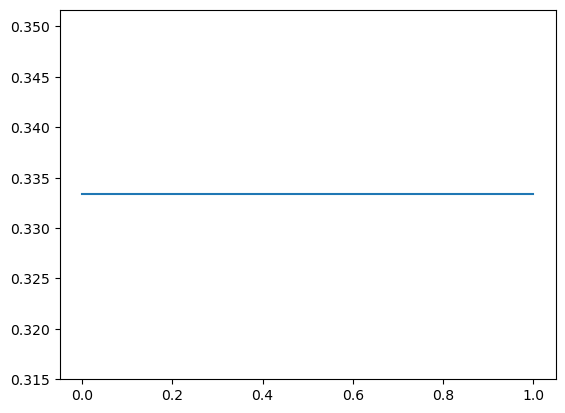

In [255]:
plt.figure()
plt.plot(theta, capacity)